In [1]:
import pandas as pd
import numpy as np 
import math
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adagrad
import random
from solution import solution
import time
import scipy
from sklearn.metrics import mean_squared_error

In [2]:
global_counter = 0

In [3]:
#load autoencoder model 
#input Layer
input_layer = tf.keras.layers.Input(shape=(4, ))
#Encoder
encoder = tf.keras.layers.Dense(3, activation="tanh")(input_layer)
encoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(1, activation="relu")(encoder)
# Decoder
decoder = tf.keras.layers.Dense(2, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(3, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(4, activation='tanh')(decoder)
#Autoencoder
anomalyDetector = tf.keras.Model(inputs=input_layer, outputs=decoder)
anomalyDetector.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
 dense_1 (Dense)             (None, 2)                 8         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
 dense_3 (Dense)             (None, 2)                 4         
                                                                 
 dense_4 (Dense)             (None, 3)                 9         
                                                                 
 dense_5 (Dense)             (None, 4)                 16    

2022-03-10 15:54:17.075677: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 15:54:20.151366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14260 MB memory:  -> device: 0, name: Tesla V100-DGXS-16GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2022-03-10 15:54:20.152996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14592 MB memory:  -> device: 1, name: Tesla V100-DGXS-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2022-03-10 15:54:20.154578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device

In [4]:
anomalyDetector.load_weights('AE_tuneActivation_code_relu.h5')

In [5]:
dataset = pd.read_csv("GMM_values.csv", header=0)

#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])
        
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None
    
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)
    
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul

#get starting points 
startingPoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        timePoint = row['Timestep'] + 1
        startingPoints.append(timePoint)

def getTimeFromStart(current, startList):
    currentEpisodeStartIndex = -1 #initialise negative value first
    for s in range(len(startList)):
        start = startList[s]
        if start - current > 0: 
            break 
        currentEpisodeStartIndex = s
    if currentEpisodeStartIndex >= 0:
        startPointTime = startList[currentEpisodeStartIndex]
        diff = current - startPointTime
        return int(diff)
    else: 
        return current

#get data on time elapsed from start of episode 
total_time_from_start = []
for timePoint in timeX:
    current_time_from_start = getTimeFromStart(timePoint, startingPoints)
    total_time_from_start.append(current_time_from_start)
    
all_df['Time_elapsed'] = total_time_from_start

anomalyData = []

for index, row in all_df.iterrows():
    sensorReadings = np.array([row['Volt'], row['Rotate'], row['Pressure'], row['Vibration']])
    sensorReadings = np.reshape(sensorReadings, (1,4))
    predictions = anomalyDetector.predict(sensorReadings)
    anomalyScore = (np.mean(np.power(sensorReadings - predictions, 2), axis=1))**0.5
    
    if anomalyScore < 0.0838:
        isAnomaly = 0
    else:
        isAnomaly = 1
        
    anomalyData.append(isAnomaly)
    
all_df['Anomalous'] = anomalyData

#drop na columns 
all_df = all_df.dropna()

In [6]:
#data processing
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['Time_elapsed'], row['Anomalous'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)
        
num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

#split into training, validation and test sets
train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [7]:
def splitDataIntoChunks3DWithAnomalyTimeInfo(data, chunk_size):
    X_split = []
    y_split = []
    time_split = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size:
                episode_chunk = []
                for i in range(0, chunk_size):
                    reading = episode[order+i]
                    episode_chunk.append(reading[1:7])
                X_split.append(episode_chunk)
                y_split.append(episode[order+chunk_size][7])
                time_split.append(int(episode[order+chunk_size][0]))
    return (X_split, y_split, time_split)

In [8]:
#set random seed 
tf.random.set_seed(42)

In [9]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

In [10]:
(trainX_4step_TAD, trainY_4step_TAD, trainTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(train_data, 4)
(valX_4step_TAD, valY_4step_TAD, valTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(val_data, 4)
(testX_4step_TAD, testY_4step_TAD, testTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(test_data, 4)

trainX_4step_TAD_arr = np.array(trainX_4step_TAD)
trainY_4step_TAD_arr = np.array(trainY_4step_TAD)
trainY_4step_TAD_arr = trainY_4step_TAD_arr.reshape(-1, 1)

valX_4step_TAD_arr = np.array(valX_4step_TAD)
valY_4step_TAD_arr = np.array(valY_4step_TAD)
valY_4step_TAD_arr = valY_4step_TAD_arr.reshape(-1, 1)

In [11]:
def findFitnessScore(lst):
    
    #get parameters
    numFilters1 = int(lst[0])
    numFilters2 = int(lst[1])
    numFilters3 = int(lst[2])
    dr1 = lst[3]
    dr2 = lst[4]
    numNeurons1 = int(lst[5])
    lr_factor = int(lst[6])
    lr = 10**(-lr_factor)
    beta1 = lst[7]
    beta2 = lst[8]
    epsilon = lst[9]
    global global_counter
    
    #build model architecture
    #configure architecture 
    model = models.Sequential()
    model.add(layers.Conv1D(filters=numFilters1, kernel_size=3, activation='relu', input_shape=(4, 6), padding="same"))
    model.add(layers.Conv1D(filters=numFilters2, kernel_size=2, activation='relu', padding="same"))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(layers.Dropout(dr1))
    model.add(layers.Conv1D(filters=numFilters3, kernel_size=1, activation='relu'))
    model.add(layers.Dropout(dr2))
    model.add(layers.Flatten())
    model.add(layers.Dense(numNeurons1, activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    
    adam = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1, beta_2=beta2, epsilon=epsilon)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])
    
    #save best model
    fileName = "CNN_tuneWithGWO_withTime.h5"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)
    
    model.fit(trainX_4step_TAD_arr, trainY_4step_TAD_arr, epochs=500, batch_size=32, validation_data=(valX_4step_TAD_arr, valY_4step_TAD_arr), shuffle=False, verbose=0, callbacks=[model_checkpoint_callback])
    
    bestModel = tf.keras.models.load_model("CNN_tuneWithGWO_withTime.h5")
    valPredict = bestModel.predict(valX_4step_TAD_arr)
    valScore = math.sqrt(mean_squared_error(valY_4step_TAD_arr, valPredict))
    valR2Score = r2_score(valY_4step_TAD_arr, valPredict)
    valsScore = findSscore(valY_4step_TAD_arr, valPredict)
    params_lst = [numFilters1, numFilters2, numFilters3, dr1, dr2, numNeurons1, lr, beta1, beta2, epsilon]
    print(f'Validation Score: {valScore} RMSE {valR2Score} R2 Score {valsScore} S score at round {global_counter} for parameters {params_lst}')
    
    global_counter += 1
    
    return (valsScore, params_lst)

In [12]:
def GWO(modelTraining, lowerBoundValuesList, upperBoundValuesList, numParams, numWolves, Max_iter):

    # Max_iter=1000
    # upperBoundValuesList= list of upper bound of parameter values 
    # lowerBoundValuesList = list of lower bound of parameter values
    # numParams = number of hyperparameters to tune 
    # numWolves = 5
    # modelTraining = function to train machine learning model 
    
    #show best params of alpha wolf
    bestParams = []

    # initialize alpha, beta_pos
    Alpha_pos = np.zeros(numParams)
    Alpha_score = float("inf")

    Beta_pos = np.zeros(numParams)
    Beta_score = float("inf")

    # Initialize the positions of search agents
    Positions = np.zeros((numWolves, numParams))
    for i in range(numParams):
        Positions[:, i] = (
            np.random.uniform(0, 1, numWolves) * (upperBoundValuesList[i] - lowerBoundValuesList[i]) + lowerBoundValuesList[i]
        )

    Convergence_curve = np.zeros(Max_iter)
    s = solution()

    timerStart = time.time()
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    
    #initialise parameters 
    wa = 0.5
    
    # Main loop
    for l in range(0, Max_iter):
        for i in range(0, numWolves):

            # Return back the wolves that go beyond the boundaries of the search space
            for j in range(numParams):
                Positions[i, j] = np.clip(Positions[i, j], lowerBoundValuesList[j], upperBoundValuesList[j]) #numpy.clip limits values in an array

            # Calculate objective function for each wolf
            (fitness, params) = modelTraining(Positions[i, :])

            # Update Alpha, Beta, and Delta
            if fitness < Alpha_score: #this is new alpha wolf 
                Beta_score = Alpha_score  # Update beta
                Beta_pos = Alpha_pos.copy()
                Alpha_score = fitness
                # Update alpha
                Alpha_pos = Positions[i, :].copy()
                bestParams = params

            if fitness > Alpha_score and fitness < Beta_score: #this is beta wolf 
                Beta_score = fitness  # Update beta
                Beta_pos = Positions[i, :].copy()

        theta = l/Max_iter
        fraction = ((math.tanh(theta))**2 + (theta*math.sin(math.pi*theta))**5)/(math.tanh(1))**2
        factor = fraction * (math.pi/2)
        a = 2 * (math.cos(factor))**2 #exploration rate 
        
        #chaotic dominance 
        wa = 2.3 * (wa**2) * math.sin(math.pi*wa)
        wbd = 0.5 * (1-wa)
            
        if (l < 0.8*Max_iter):

            # Update the Position of search agents including omegas
            for i in range(0, numWolves):
                for j in range(0, numParams):
                    
    
                    r1 = random.random()
                    r2 = random.random()
                    A1 = (2*r1 - 1)*a
                    C1 = 2 * r2
    
                    D_alpha = abs(C1 * Alpha_pos[j] - Positions[i, j])
                    # Equation (3.5)-part 1
                    X1 = Alpha_pos[j] - A1 * D_alpha
                    # Equation (3.6)-part 1
    
                    r1 = random.random()
                    r2 = random.random()
    
                    A2 = (2*r1 - 1)*a
                    # Equation (3.3)
                    C2 = 2 * r2
                    # Equation (3.4)
    
                    D_beta = abs(C2 * Beta_pos[j] - Positions[i, j])
                    # Equation (3.5)-part 2
                    X2 = Beta_pos[j] - A2 * D_beta
                    # Equation (3.6)-part 2
    
                    Positions[i, j] = wa*X1 + wbd*X2 # update position of each wolf
                    
        else: 
            
            # Update the Position of search agents including omegas
            for i in range(0, numWolves):
                for j in range(0, numParams):
                    
                    amplitude = 1 - (0.05*(l - 0.8*Max_iter))
                    rand = random.uniform(-1, 1) #generate random float between -1 and 1 
                    step_size = amplitude * (math.exp(3*(rand**2)*0.5)) * math.cos(math.pi*rand) * math.sin(math.pi*rand)
                    Positions[i, j] = Alpha_pos[j] - step_size*abs(Alpha_pos[j] - Positions[i, j])

        Convergence_curve[l] = Alpha_score

        if l % 1 == 0:
            print(
                "At iteration " + str(l) + " the best S score is " + str(Alpha_score)
            )
            print(bestParams)

    timerEnd = time.time()
    s.endTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    s.executionTime = timerEnd - timerStart
    s.convergence = Convergence_curve
    s.bestIndividual = bestParams
    s.best = Alpha_score

    return s

In [13]:
paramsUpperBoundList = [4096, 2048, 1024, 0.95, 0.95, 4096, 10, 0.999, 0.999, 5]
paramsLowerBoundList = [1, 1, 1, 0, 0, 1, 0, 0, 0, 0.1]
numParams = 10

In [14]:
result = GWO(findFitnessScore, paramsLowerBoundList, paramsUpperBoundList, numParams, 5, 30)

2022-03-10 16:02:07.298944: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


Validation Score: 5.435810104856772 RMSE -1.5793974329220561 R2 Score 913.251694683537 S score at round 0 for parameters [3777, 1552, 210, 0.42301603366274126, 0.7497304202459437, 1891, 1, 0.1658854228552624, 0.5475392051817545, 0.20677112902970285]
Validation Score: 5.392119486652663 RMSE -1.5380999746566428 R2 Score 910.0392083011267 S score at round 1 for parameters [3143, 1879, 608, 0.1428624307037438, 0.4005835464993584, 221, 1e-08, 0.482887078176915, 0.800398377910834, 1.1712539895604308]
Validation Score: 5.435810104856772 RMSE -1.5793974329220561 R2 Score 913.251694683537 S score at round 2 for parameters [2610, 989, 456, 0.38902180092134564, 0.06511783582643994, 2822, 1e-09, 0.4683712974717498, 0.8573046541275189, 3.8740335304489317]
Validation Score: 5.3894003811653395 RMSE -1.5355408245869704 R2 Score 909.8728915910644 S score at round 3 for parameters [4091, 1522, 850, 0.38104755459565676, 0.21367743704723174, 1692, 1e-08, 0.5784029844497831, 0.6720513442489034, 2.108403558

In [15]:
print(f"Best hyperparameters: {result.bestIndividual} with score {result.best}")

Best hyperparameters: [2737, 360, 78, 0.4358910532296705, 0.0001837537352680288, 3495, 0.001, 0.035821945808348674, 0.4489307538261566, 0.1066162771521442] with score 785.31867266152


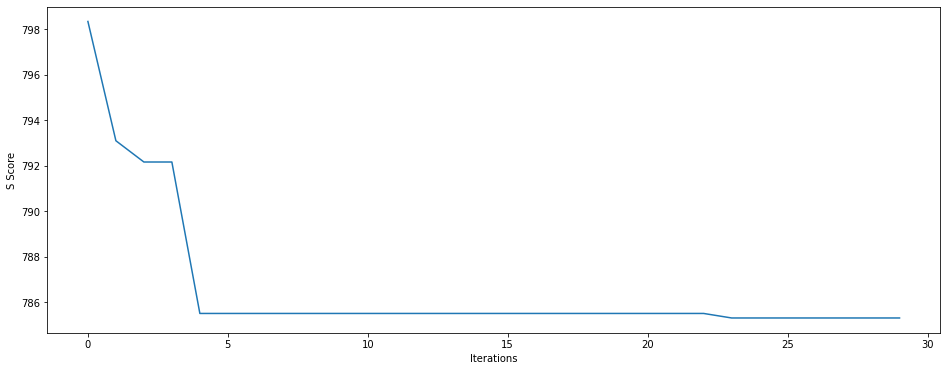

In [16]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(16, 6))
plt.plot(result.convergence)
plt.ylabel('S Score')
plt.xlabel('Iterations')
plt.show()